In [10]:
import json
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

In [3]:
##Load in Train Set
X_train_path = "../data/preprocessed_data/training/X_train_enc.parquet"
X_train = pd.read_parquet(X_train_path)
y_train_path = "../data/preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

## Load in Test Set
X_test_path = "../data/preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "../data/preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "../data/preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "../data/preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))


In [4]:
def random_forest(X_train, y_train, X_test, y_test):
    #create base random forest classifier
    rfc = RandomForestClassifier(random_state = 42)
    rfc.fit(X_train, y_train)
    y_train = rfc.predict(X_train)
    y_pred = rfc.predict(X_test)
    print('Model training accuracy score with Random Forest : {0:0.4f}'. format(accuracy_score(y_train, y_train)))
    print('Model testing accuracy score with Random Forest : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    
    #confusion matrix plot
    plot_confusion_matrix(rfc, X_test, y_test) 
    plt.title('Random Forest Confusion Matrix')
    plt.show()
    
    y_pred1 = rfc.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
    rf_roc_auc = roc_auc_score(y_test, y_pred1)

    #plot roc curve
    plt.figure()
    plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred1)
    auc_precision_recall = auc(recall, precision)

    #create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

    results = {"fpr": fpr, "tpr": tpr, "roc": rf_roc_auc, "precision": precision, "recall": recall, "pr": auc_precision_recall}

    return results

## Stages to perform

### 1. Classification on all columns
### 2. Classification on selected features from feature importance
### 3. Classification on features from PCA
### 4. Hyperparameter tune based on best model

<ipython-input-4-d846838e3605>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Model training accuracy score with Random Forest : 1.0000
Model testing accuracy score with Random Forest : 0.9587


/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


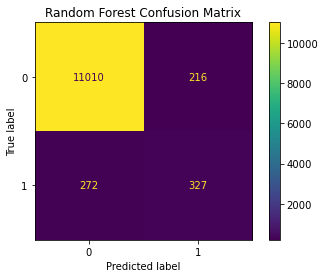

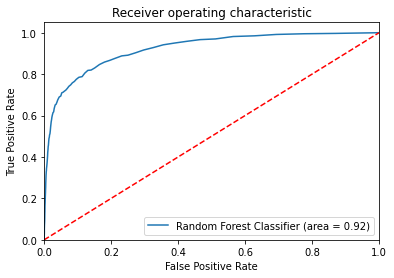

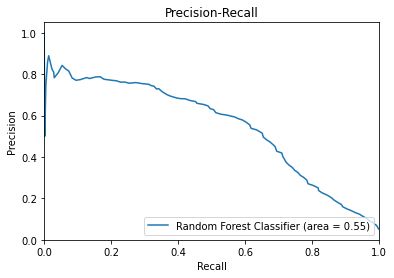

In [5]:
base = random_forest(X_train, y_train, X_test, y_test)

## Feature Selection

In [7]:
def var_selection(X_train_new, y_train):
    rf_vs = RandomForestClassifier(random_state = 42)
    rf_vs.fit(X_train_new, y_train)
    sel = SelectFromModel(rf_vs)
    sel.fit(X_train_new, y_train)
    best_var = X_train_new.columns[(sel.get_support())]
    print(best_var)
    return best_var

In [8]:
best_var = var_selection(X_train, y_train)

<ipython-input-7-af5a3aa8c198>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_vs.fit(X_train_new, y_train)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:355: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Index(['std_-1_25', 'std_-1_50', 'std_-1_mean', 'std_-1_min', 'mean_-1_25',
       'mean_-1_50', 'mean_-1_75', 'mean_-1_mean', 'mean_-1_max', 'std_0_25',
       'std_0_50', 'std_0_75', 'std_0_mean', 'std_0_min', 'std_0_max',
       'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min',
       'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min',
       'relative_position', 'position_1_G', 'position_5_T'],
      dtype='object')


<ipython-input-21-fd2c8d1553f1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Model training accuracy score with Random Forest : 1.0000
Model testing accuracy score with Random Forest : 0.9567


/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


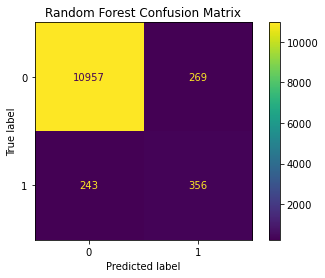

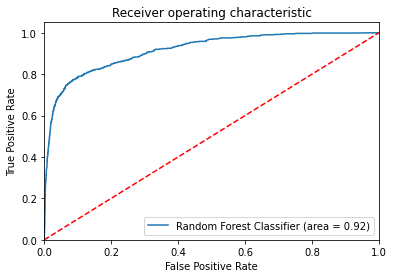

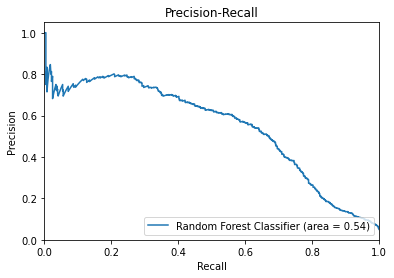

In [26]:
best_var_model = random_forest(X_train[best_var], y_train, X_test[best_var], y_test)

## PCA

In [11]:
pca = PCA(0.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [12]:
pca.n_components_

26

In [13]:
X_train_pca = pd.DataFrame(pca.transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
X_val_pca = pd.DataFrame(pca.transform(X_val))

<ipython-input-21-fd2c8d1553f1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Model training accuracy score with Random Forest : 1.0000
Model testing accuracy score with Random Forest : 0.9506


/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


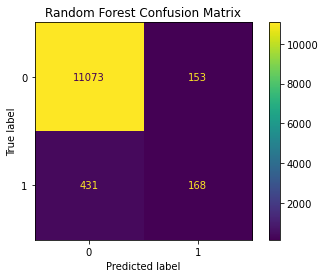

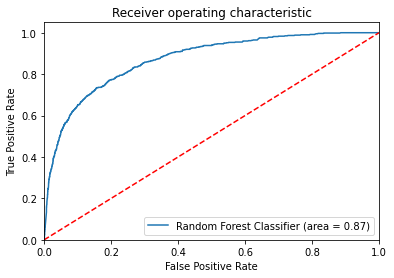

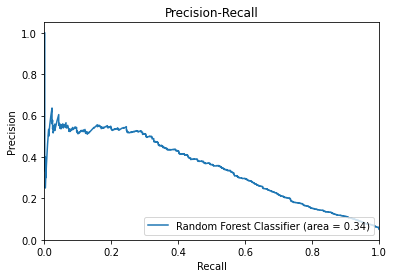

In [27]:
pca_model = random_forest(X_train_pca, y_train, X_test_pca, y_test)

In [19]:
def params_tuning(random_grid, X_val, y_val):
    rf = RandomForestClassifier(random_state = 42)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)
    rf_random.fit(X_val, y_val)
    return rf_random.best_params_

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 301, 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [20]:
best_params = params_tuning(random_grid, X_val[best_var], y_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [77]:
best_params

{'n_estimators': 245,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [21]:
def random_forest(X_train, y_train, X_test, y_test):
    #create base random forest classifier
    rfc = RandomForestClassifier(random_state = 42, n_estimators=245, min_samples_split=5, min_samples_leaf=2, max_features='auto',
            max_depth=70, bootstrap=False)
    rfc.fit(X_train, y_train)
    y_train = rfc.predict(X_train)
    y_pred = rfc.predict(X_test)
    print('Model training accuracy score with Random Forest : {0:0.4f}'. format(accuracy_score(y_train, y_train)))
    print('Model testing accuracy score with Random Forest : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    #confusion matrix plot
    plot_confusion_matrix(rfc, X_test, y_test) 
    plt.title('Random Forest Confusion Matrix')
    plt.show()
    y_pred1 = rfc.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
    rf_roc_auc = roc_auc_score(y_test, y_pred1)
    #plot roc curve
    plt.figure()
    plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred1)
    auc_precision_recall = auc(recall, precision)
    #create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

<ipython-input-21-fd2c8d1553f1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Model training accuracy score with Random Forest : 1.0000
Model testing accuracy score with Random Forest : 0.9567


/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


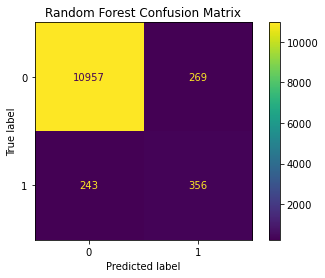

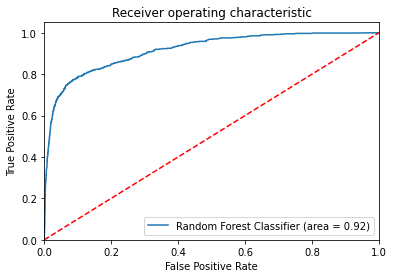

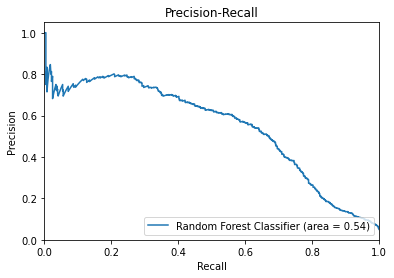

In [28]:
hyperparameter_model = random_forest(X_train[best_var], y_train, X_test[best_var], y_test)

## Comparing All 4 Models

1. Base
2. With feature selection
3. With PCA
4. With feature selection and hyperparameter tuning

In [29]:
models = [base, best_var_model, pca_model, hyperparameter_model] # still need to add in the other models
titles = ["Random Forest", "With Feature Selection",
            "With PCA", "With Feature Selection + Tuning"]

TypeError: 'NoneType' object is not subscriptable

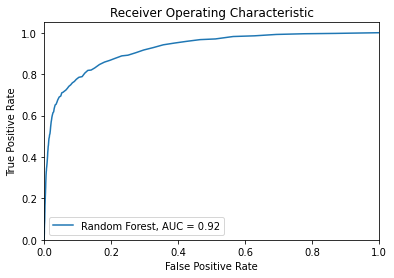

In [30]:
# ROC Curve
for model, title in zip(models, titles):
    plt.plot(model["fpr"], model["tpr"], label = f"{title}, AUC = %0.2f" % model["roc"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()

In [ ]:
# PR Curve
for model, title in zip(models, titles):
    plt.plot(model["precision"], model["recall"], label = f"{title}, PR = %0.2f" % model["pr"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall')
    plt.legend()